In [6]:
### imports
import numpy as np
import matplotlib.pyplot as plt
import itertools
import copy
from numba import njit
from scipy import ndimage

In [7]:
### define the function we will use
@njit()
def get_neighbours(i, j, size_of_grid):
    """
    Returns the existing neighbours of the current position
    if a neighbour would fall out of bounds it is treated the same as if it would have a vaule of 0

    Using njit for just in time compilation, to reduce runtime
    """

    position = np.array([i, j])
    arrangements = np.array([[1, 0], [-1, 0], [0, 1], [0, -1]])
    neighbours = []

    for a in arrangements:
        new_position = position + a

        # check if the position is out of bounds
        if(0 <= new_position[0] < size_of_grid and 0 <= new_position[1] < size_of_grid):
            neighbours.append(new_position)
    
    return neighbours

@njit()
def calculate_new_grid_value(i, j, grid, size_of_grid):
    """
    calculates the new value of a grid position using the formula we got in the lecture

    using njit for just in time compilation, to reduce runtime
    """
    neighbours = get_neighbours(i, j, size_of_grid)
    # calculate the values of all the neighbours and then use this to 
    value_to_add = 0
    for neighbour in neighbours:
        value_to_add += grid[neighbour[0], neighbour[1]]

    new_value = 0.25 * value_to_add
    return new_value

def create_basic_components(size_of_grid):
    """
    creates the basic components for this exercise,
    this is its own method as i want to automate the data collection for exercise 3

    using njit for just in time compilation, to reduce runtime
    """
    zeros_array = np.zeros((size_of_grid, size_of_grid))

    ## create the default array with 0 on the bounds and 1000 in the center
    basic_matrix = np.zeros_like(zeros_array)
    basic_matrix[int(size_of_grid / 2), int(size_of_grid / 4):int(size_of_grid / 4 + size_of_grid / 2)] = 1000

    # create the definition for where we want to upgrade our array
    update_mask = np.ones_like(zeros_array, dtype=bool)
    update_mask[0, :] = False
    update_mask[-1, :] = False
    update_mask[:, 0] = False
    update_mask[:, -1] = False
    update_mask[int(size_of_grid / 2), int(size_of_grid / 4):int(size_of_grid / 4 + size_of_grid / 2)] = False

    return basic_matrix, update_mask

def nested_loop_method(basic_matrix, update_mask, size_of_grid=100, w_value=1, threshhold=10**-3, max_iterations=10000):
    """
    Uses the jacobian method with nested loops

    using njit for just in time compilation, to reduce runtime
    """
    ## now we use the simple jacobian without a checkerboard pattern,
    # for this we iterate over each point, save its new value in a new array

    points = [(x,y) for x in range(size_of_grid) for y in range(size_of_grid)]

    # create the matricies needed for this iteration
    jacobian_basic = basic_matrix.copy()
    updated_matrix = np.zeros_like(jacobian_basic)
    diff_matrix = jacobian_basic - update_mask

    diff = np.max(np.abs(diff_matrix))
    current_iteration = 0
    while diff > threshhold and current_iteration < max_number_of_iterations:
        # loop over each point and calculate the next value
        for point in points:
            updated_matrix[point] = calculate_new_grid_value(*point, jacobian_basic, size_of_grid)
        
        # get the highest change
        diff = np.max(np.abs(jacobian_basic[update_mask] - updated_matrix[update_mask])) 

        jacobian_basic[update_mask] = updated_matrix[update_mask]
        current_iteration += 1

    return jacobian_basic, diff, current_iteration

def checkerboard_method(basic_matrix, update_mask, size_of_grid=100, w_value=1, threshhold=10**-3, max_iterations=10000):
    """
    Uses the jacobian / sor method according to what w_value is used
    uses the checkerboard method and the np.convolve method to reduce runtime even furher

    using njit for just in time compilation, to reduce runtime
    """
    # create the matricies needed for this one
    jacobian_checkerboard = basic_matrix.copy()
    update_matrix = np.zeros_like(jacobian_checkerboard)
    diff_matrix = jacobian_checkerboard - update_mask

    # compute the checkerboard pattern
    checkerboard = np.indices((size_of_grid, size_of_grid)).sum(axis=0) % 2 == 0

    # used for the way required by the exercise
    W = np.array([[0,1,0],[1,-4,1],[0,1,0]])

    diff = np.max(np.abs(diff_matrix[update_mask]))
    current_iteration = 0
    while diff > threshhold and current_iteration <= max_iterations:

        # calculate the update the first time
        ndimage.convolve(jacobian_checkerboard, W, output = update_matrix, mode = "constant", cval = 0)
        update_matrix *= w_value / 4
        
        # define what part of the stuff we want to update
        update_matrix[~update_mask] = 0

        # update our matrix
        jacobian_checkerboard[checkerboard] = jacobian_checkerboard[checkerboard] + update_matrix[checkerboard]


        # calculate the stuff the second time
        ndimage.convolve(jacobian_checkerboard, W, output = update_matrix, mode = "constant", cval = 0)
        update_matrix *= w_value / 4

        # redefine what part of our stuff we want to upgrade
        update_matrix[~update_mask] = 0

        jacobian_checkerboard[~checkerboard] = jacobian_checkerboard[~checkerboard] + update_matrix[~checkerboard]

        diff = np.max(np.abs(update_matrix))
        current_iteration += 1

    return jacobian_checkerboard, diff, current_iteration

# Part 1 of this exercise
Use the Jacobi method on a 100x100 grid first with nested loops and then using the checkerboard implementation with either the numpy or the convolution way shown in the exercise class. Note duration and the number of iterations needed to reach convergence. Make a contour and a color plot of the resulting potential.


In [8]:
### definitions
size_of_grid = 100
max_number_of_iterations = 10000 # tested this, no need to go higher
threshhold = 10**-3

basic_matrix, update_mask = create_basic_components(size_of_grid)

In [9]:
%%time

#jacobian_basic, diff, current_iteration = nested_loop_method(basic_matrix, update_mask)

## now we plot this matrix
#fig, ax = plt.subplots()
##CPF = ax.contourf([x for x in range(100)], [x for x in range(100)], jacobian_basic, levels=100)
#CS = ax.contour([x for x in range(100)], [x for x in range(100)], jacobian_basic, np.linspace(100, 900, 9), colors='black')
#ax.clabel(CS, inline=True, fontsize=10)
#ax.set_title(f"Jacobian Basic Method: iterations: {current_iteration}")

CPU times: user 1 μs, sys: 1e+03 ns, total: 2 μs
Wall time: 1.91 μs


CPU times: user 1.08 s, sys: 15.4 ms, total: 1.1 s
Wall time: 1.12 s


Text(0.5, 1.0, 'Jacobian Checkerboard Method: iterations: 3036')

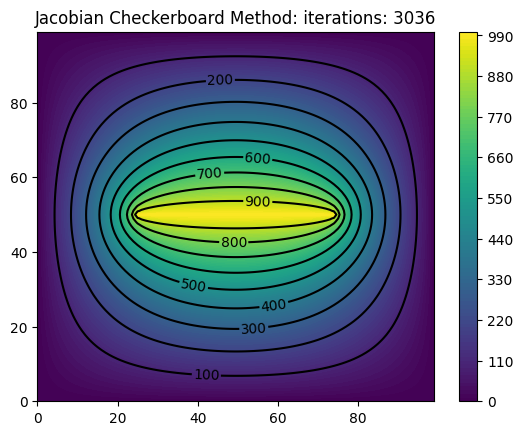

In [10]:
%%time

# using the above defined method, we can compute the jacobi (w=1) using the checkerboard method
jacobian_checkerboard, diff, current_iteration = checkerboard_method(basic_matrix, update_mask)

## now we plot this matrix
fig, ax = plt.subplots()
CPF = ax.contourf([x for x in range(size_of_grid)], [x for x in range(size_of_grid)], jacobian_checkerboard, levels=100)
CS = ax.contour([x for x in range(size_of_grid)], [x for x in range(size_of_grid)], jacobian_checkerboard, np.linspace(100, 900, 9), colors='black')
ax.clabel(CS, inline=True, fontsize=10)
fig.colorbar(CPF, ax=ax)
ax.set_title(f"Jacobian Checkerboard Method: iterations: {current_iteration}")


## Part 2 of the Exercise
Use the SOR method (using the checkerboard implementation) with omega=1.9 on a 100x100 grid and note the duration and the number of iterations needed to reach convergence. Make the plots again and compare to the result obtained with the Jacobi method.

Using the Method we have defined, we can now use w=1.9 to get the sor method

CPU times: user 90 ms, sys: 3.44 ms, total: 93.4 ms
Wall time: 92.8 ms


Text(0.5, 1.0, 'Jacobian Checkerboard Method: iterations: 172')

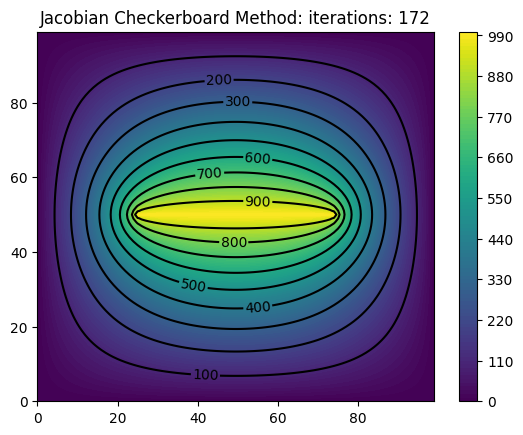

In [11]:
%%time

jacobian_checkerboard, diff, current_iteration = checkerboard_method(basic_matrix, update_mask, w_value=1.9)

## now we plot this matrix
fig, ax = plt.subplots()
CPF = ax.contourf(np.linspace(0, 99, 100), np.linspace(0, 99, 100), jacobian_checkerboard, levels=100)
CS = ax.contour(np.linspace(0, 99, 100), np.linspace(0, 99, 100), jacobian_checkerboard, np.linspace(100, 900, 9), colors='black')
ax.clabel(CS, inline=True, fontsize=10)
fig.colorbar(CPF, ax=ax)
ax.set_title(f"Jacobian Checkerboard Method: iterations: {current_iteration}")

From the time feature of jupiter notebooks, we can compare the time and iterations it takes for the three different methods we used until now:
- Jacobi with nested loops: 5458 Iterations and somewhere around 1:20 Minutes
- Jacobi with the convolution (w = 1): 3036 Iterations and 859ms
- SOR Method with (w = 1): 172 Iterations and 70ms
- I think that this is very interesting and shows why the exercise asks to implement the faster way, as waiting for this for a bigger grid would be very boring

## Part 3 of the exercise
We are now asked to find the best w value for the following grid sizes 
N=10, 20, 50, 100, 200, 500, 1000


[np.float64(1.65), np.float64(1.65005005005005), np.float64(1.6501001001001), np.float64(1.65015015015015), np.float64(1.6502002002002), np.float64(1.65025025025025), np.float64(1.6503003003003003), np.float64(1.6503503503503503), np.float64(1.6504004004004003), np.float64(1.6504504504504505), np.float64(1.6505005005005005), np.float64(1.6505505505505504), np.float64(1.6506006006006004), np.float64(1.6506506506506506), np.float64(1.6507007007007006), np.float64(1.6507507507507506), np.float64(1.6508008008008006), np.float64(1.6508508508508508), np.float64(1.6509009009009008), np.float64(1.6509509509509508), np.float64(1.651001001001001), np.float64(1.651051051051051), np.float64(1.651101101101101), np.float64(1.651151151151151), np.float64(1.6512012012012012), np.float64(1.6512512512512512), np.float64(1.6513013013013011), np.float64(1.6513513513513514), np.float64(1.6514014014014013), np.float64(1.6514514514514513), np.float64(1.6515015015015013), np.float64(1.6515515515515515), np.fl

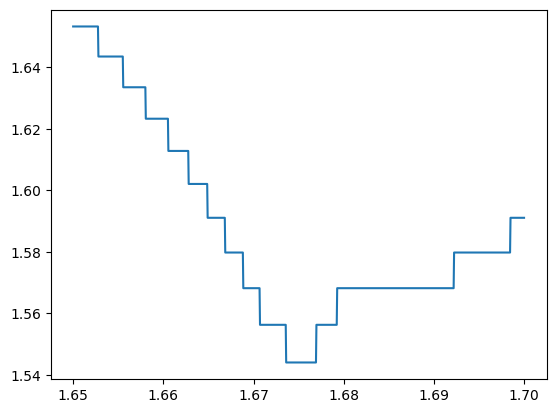

In [15]:
size = 25

#for size in [10, 20, 50, 100, 200, 500, 1000]:
w_values = []
iterations = []

basic_matrix, update_mask = create_basic_components(size)
for w in np.linspace(1.67, 1.68, 1000):
    w_values.append(w)
    jacobian_checkerboard, diff, current_iteration = checkerboard_method(basic_matrix, update_mask, w_value=w,size_of_grid=size)
    iterations.append(current_iteration)

plt.plot(w_values, np.log10(iterations), label=f'{size}')
print(w_values)
print(w_values[iterations.index(min(iterations))])
#plt.legend()

# define our basic matrix as we did above 


Here is the required table:

Size of Grid    | Best w Value  |
__________________________________
      10        |   1.36363     |
      20        |   1.61414     |
      50        |   1.82626     |
     100        |   1.90939     |
     200        |   1.94777     |
     500        |   1.98055     |
     1000       |   1.98111     |
